# EMG Data Preprocessing

This notebook contains the preprocessing steps needed to be done on the data before the ML pipeline takes over.

### TODO
[] reassign channel numbers after removing then, currently reassigns sequentially (dictionary?)

In [149]:
import librosa
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import scipy.signal as signal

In [150]:
# Global parameters used in preprocessing

FILENAME = "../tests/rock4.txt" 
NUM_CHANNELS = 2
UNWANTED_CHANNELS = [2]

NFFT = 128
SAMPLE_RATE = 1152
LOW_CUTOFF = 10
HIGH_CUTOFF = 450

In [151]:
# Open the .txt containing the sensor output
# and then store the values for plotting

with open(FILENAME, "r") as f:
  temp = f.read().splitlines()

num_points = len(temp)
raw_data = np.zeros((NUM_CHANNELS, num_points))
for c, t in enumerate(temp):
  split = t.split(',')
  # we want to loop through channels that we need, and can disregard others
  for i in (i for i in range(len(split)) if i not in UNWANTED_CHANNELS):
    raw_data[i][c] = split[i]

# Create time axis for graphs
time_axis = np.linspace(0, len(raw_data[0]) / SAMPLE_RATE, len(raw_data[0]))

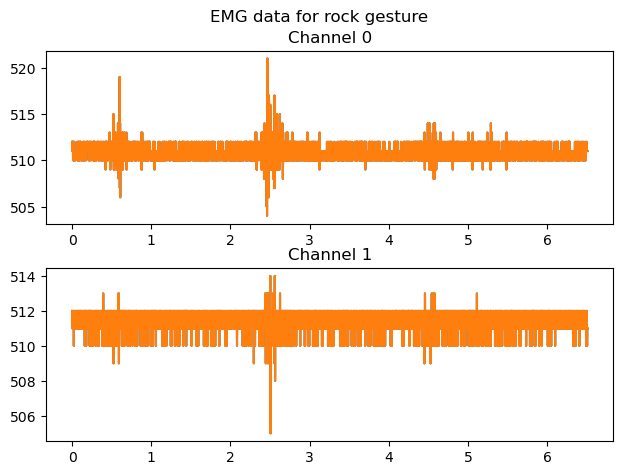

In [152]:
fig, axs = plt.subplots(len(raw_data))
fig.suptitle('EMG data for rock gesture')
fig.tight_layout()

for c, i in enumerate(raw_data):
  axs[c].plot(time_axis, i)
  axs[c].plot(time_axis, i)
  axs[c].set_title(f"Channel {c}")

plt.show()

## Normalizing data

In [153]:
for a in range(len(raw_data)):
  # as you want your data to be between -1 and 1, everything should be scaled to 2, 
  # if your desired min and max are other values, replace 2 with your_max - your_min
  ratio = 2 / (np.max(raw_data[a]) - np.min(raw_data[a])) 
  shift = (np.max(raw_data[a]) + np.min(raw_data[a])) / 2 
  # now you need to shift the center to the middle, this is not the average of the values.
  raw_data[a] = (raw_data[a] - shift) * ratio

## Defining lowpass and highpass filters

In [154]:
def highpass_filter(data, cutoff, fs, order=5):
    # nyq = 0.5 * fs
    # normal_cutoff = cutoff / nyq
    # print(normal_cutoff)
    b, a = signal.butter(order, cutoff, fs=SAMPLE_RATE, btype='highpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    # nyq = 0.5 * fs
    # normal_cutoff = cutoff / nyq
    # print(normal_cutoff)
    b, a = signal.butter(order, cutoff, fs=SAMPLE_RATE, btype='lowpass', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


## Applying filters

In [155]:
filtered_signal = np.zeros((NUM_CHANNELS, num_points))

for idx, channel_data in enumerate(raw_data):
  filtered_signal[idx] = highpass_filter(raw_data[idx], LOW_CUTOFF, SAMPLE_RATE)
  filtered_signal[idx] = lowpass_filter(filtered_signal[idx], HIGH_CUTOFF, SAMPLE_RATE)

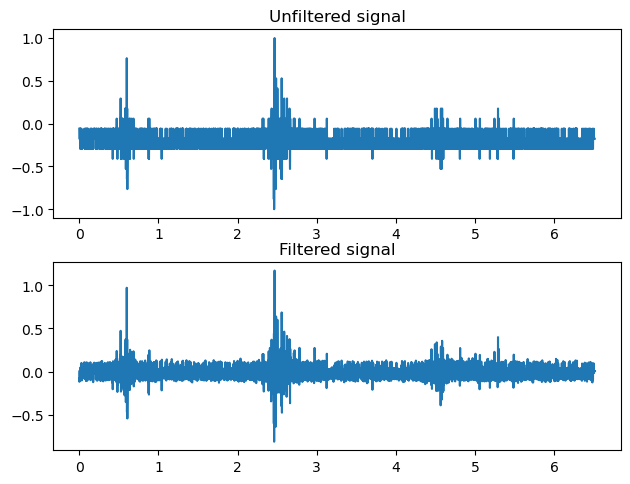

In [156]:
fig, axs = plt.subplots(2)
fig.tight_layout()
axs[0].plot(time_axis, raw_data[0])
axs[0].set_title(f"Unfiltered signal")
axs[1].plot(time_axis, filtered_signal[0])
axs[1].set_title(f"Filtered signal")
plt.show()

## Performing STFT

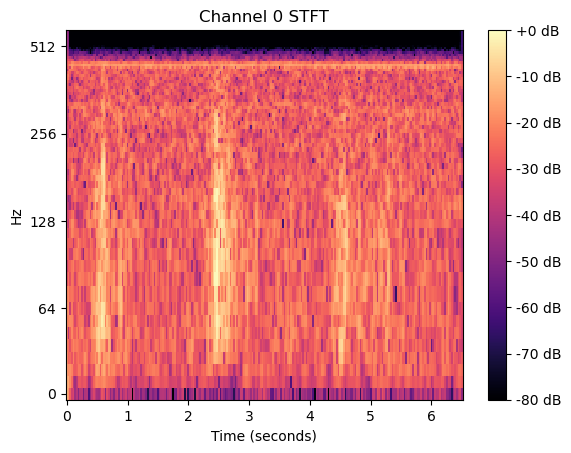

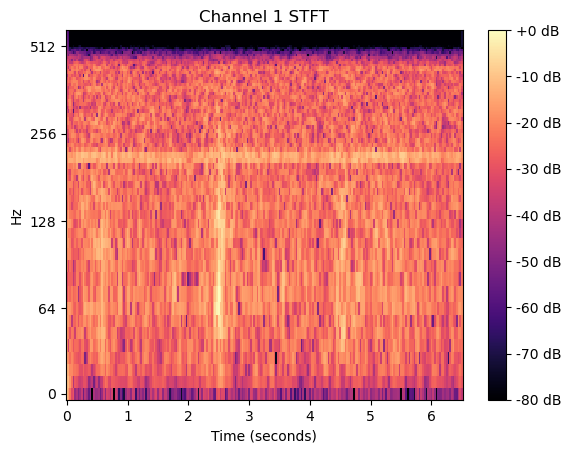

In [157]:
stft_channels = []
for idx, filtered_channel in enumerate(filtered_signal):
  stft_channels.append(librosa.stft(filtered_channel, n_fft=NFFT))

# Plot STFT results
for idx, stft_result in enumerate(stft_channels):
  fig, ax = plt.subplots()
  img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_result),
                                                        ref=np.max),
                                y_axis='log', x_axis='s', ax=ax, sr=SAMPLE_RATE,
                                  n_fft=NFFT, hop_length=NFFT/4)
  ax.set_title(f"Channel {idx} STFT")
  fig.colorbar(img, ax=ax, format="%+2.0f dB")
  plt.show()